In [1]:
import math
import numpy as np
from matplotlib import pyplot as plt

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

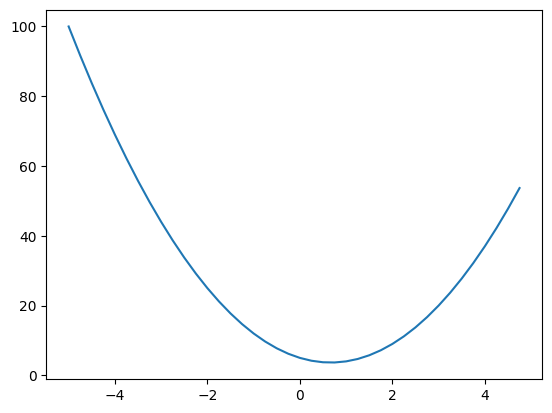

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

Gradient definition

$$ \frac{df}{da} = \lim_{h\to0} \frac{f(a+h)-f(a)}{h} $$

but in autograd engines it is approx'd. we should keep h very small so converge to exact gradient but not too close to a point where float datatype cant represent it / its operations.

In [4]:
h = 0.000000000001
x = 3.0
(f(x+h) - f(x)) / h

14.001244608152774

but

In [5]:
h = 0.0000000000000001
x = 3.0
(f(x + h) - f(x)) / h

0.0

In [6]:
h = 0.000000000001
x = -3.0
(f(x + h) - f(x)) / h

-21.9984030991327

In [7]:
h = 0.000001
x = 2/3
(f(x + h) - f(x)) / h

2.999378523327323e-06

In [8]:
# complex example
a = 2.0
b = -3.0
c = 10.0
d = a*b + c 
print(d)

4.0


In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c

a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [10]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

b += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0002
slope 2.0000000000042206


In [11]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a * b + c

c += h
d2 = a * b + c

print("d1", d1)
print("d2", d2)
print("slope", (d2 - d1) / h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [12]:
class Value:
    
    def __init__(self, data):
        self.data = data
    
    def __repr__(self):
        return f"Value(data={self.data})"

a = Value(2.0)
a

Value(data=2.0)

In [13]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), '+')
        return out
    
    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), '*')
        return out
    
    def tanh(self):
        e = math.exp(2 * self.data)
        t = (e - 1) / (e + 1)
        return Value(t, (self,), 'tanh')


a = Value(2.0, label='a')
b = Value (-3.0, label='b')
c = Value (10.0, label='c')
e = a * b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

In [14]:
from graphviz import Digraph

def trace(root):
    # builds a set of all nodes and edges in a graph
    nodes, edges = set(), set()

    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)

    build(root)
    return nodes, edges


def draw_dot(root):
    dot = Digraph(format="svg", graph_attr={"rankdir": "LR"})  # LR = left to right

    nodes, edges = trace(root)
    for n in nodes:
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(
            name=uid,
            label="{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad),
            shape="record",
        )
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)

    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot


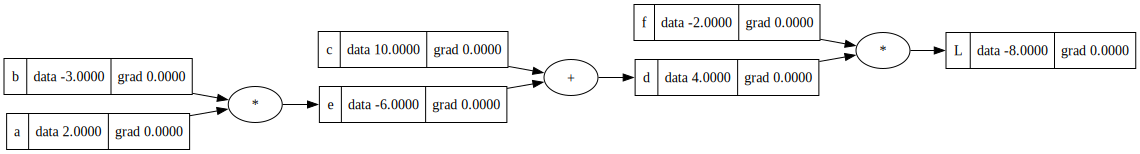

In [15]:
draw_dot(L)

Chain Rule intuition - "If a car travels twice as fast as a bicycle and the bicycle is four times as fast as a walking man, then the car travels 2 × 4 = 8 times as fast as the man."
$$
\begin{align}
\frac{dL}{dL} &= 1 \\
\frac{dL}{df} &= d = 4.0 \text{ given } L = f * d \\
\frac{dL}{dd} &= f = -2.0  \text{ given } L = f * d \\
\frac{dd}{dc} &= 1.0  \text{ given } d = e + c \\
\frac{dd}{de} &= 1.0  \text{ given } d = e + c \\
\frac{dL}{dc} &= \frac{dL}{dd} * \frac{dd}{dc} = -2.0 * 1.0 = -2.0 \\
\frac{dL}{de} &= \frac{dL}{dd} * \frac{dd}{de} = -2.0 * 1.0 = -2.0 \\
\frac{de}{da} &= b = -3.0 \text{ given } e = a * b \\
\frac{dL}{da} &= \frac{dL}{de} * \frac{de}{da} = -2.0 * -3.0 = 6.0 \\
\frac{de}{db} &= a = 2.0 \text{ given } e = a * b \\
\frac{dL}{db} &= \frac{dL}{de} * \frac{de}{db} = -2.0 * 2.0 = -4.0 \\
\end{align}
$$

In [16]:
L.grad = 1
f.grad = 4.0
d.grad = -2.0
c.grad = -2.0
e.grad = -2.0
a.grad = 6.0
b.grad = -4.0

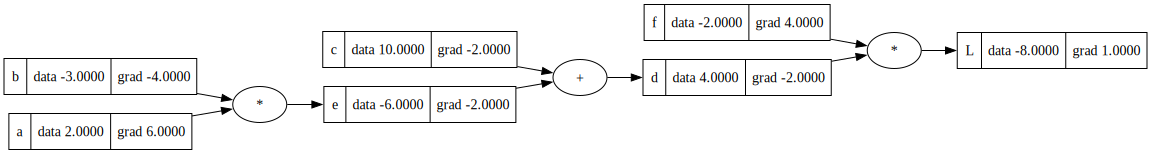

In [17]:
draw_dot(L)

nodging data positively by its gradient will increase L

In [18]:
# only leaf nodes
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = c + e
L  = d * f
L

Value(data=-7.286496)

simple neuron

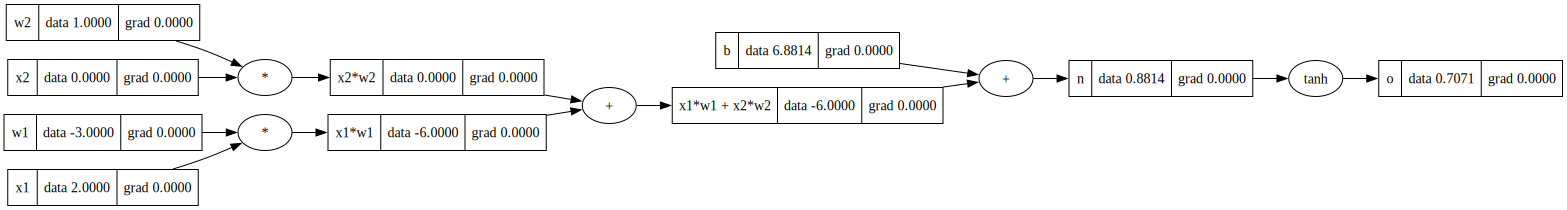

In [19]:
# inputs
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label="x1*w1"
x2w2 = x2*w2; x2w2.label="x2*w2"
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label="x1*w1 + x2*w2"
n = x1w1x2w2 + b; n.label='n'
o = n.tanh(); o.label = 'o'
draw_dot(o)

$$
\begin{align}
\frac{do}{do} = 1 \\
\frac{do}{dn} = 1 - \tanh{n}^2 = 1 - o^2 = 0.5 \\
\frac{dx1w1x2w2}{dn} = 1 * 0.5 = 0.5 \\
\frac{db}{dn} = 1 * 0.5 = 0.5 \\
\frac{dx1w1}{dn} = 1 * 0.5 = 0.5 \\
\frac{dx2w2}{dn} = 2 * 0.5 = 0.5 \\
\frac{dx1}{dn} = w1 * \frac{dx1w1}{dn} = -1.5 \\
\frac{dw1}{dn} = x1 * \frac{dx1w1}{dn} = 1.0 \\
\frac{dx2}{dn} = w2 * \frac{dx2w2}{dn} = 0.5 \\
\frac{dw2}{dn} = x2 * \frac{dx2w2}{dn} = 0.0 \\
\end{align}
$$

In [20]:
o.grad = 1
x1w1x2w2.grad = b.grad = x1w1.grad = x2w2.grad = x2.grad = 0.5
w2.grad = 0
x1.grad = -1.5
w2.grad = 1.0

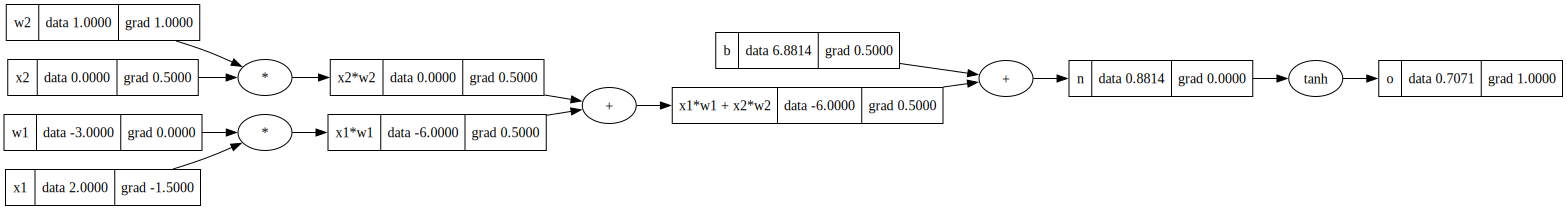

In [21]:
draw_dot(o)

In [22]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")
        
        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad
            
        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")
        
        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad
            
        out._backward = _backward
        return out

    def tanh(self):
        e = math.exp(2 * self.data)
        t = (e - 1) / (e + 1)
        out = Value(t, (self,), "tanh")
        
        def _backward():
            self.grad = (1 - t**2) * out.grad
            
        out._backward = _backward
        return out


In [23]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"


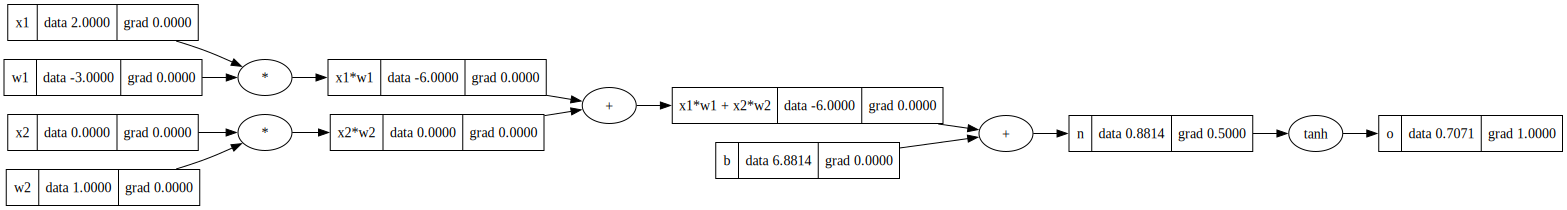

In [24]:
o.grad = 1.0
o._backward()
draw_dot(o)

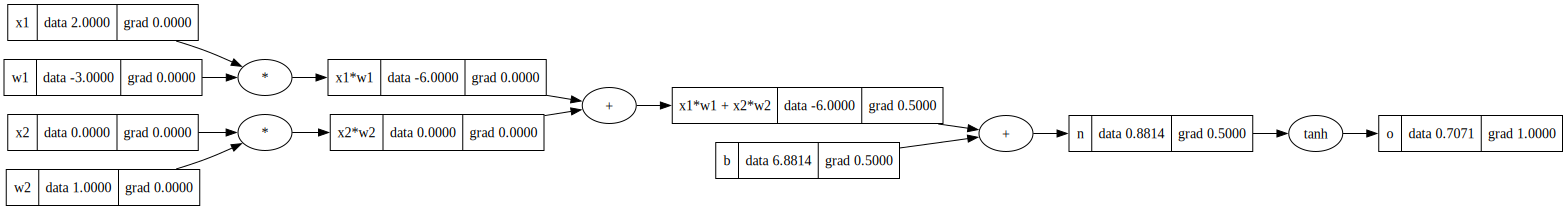

In [25]:
n._backward()
draw_dot(o)

In [26]:
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()

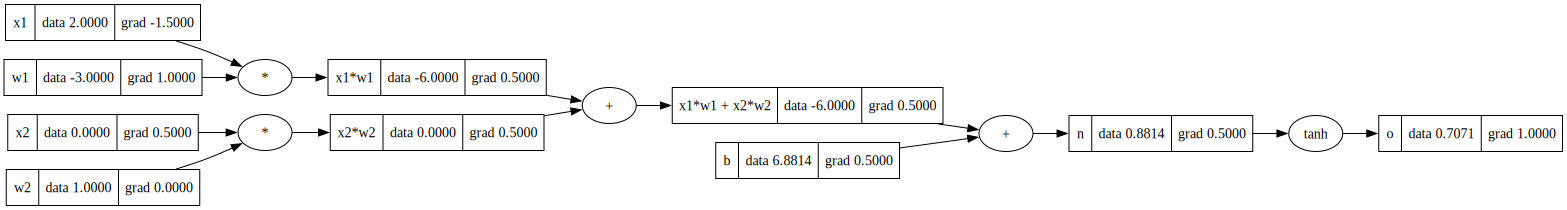

In [27]:
draw_dot(o)

Topological ordering

In [28]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad = 1.0 * out.grad
            other.grad = 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad = other.data * out.grad
            other.grad = self.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        e = math.exp(2 * self.data)
        t = (e - 1) / (e + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad = (1 - t**2) * out.grad

        out._backward = _backward
        return out

    def backward(self):
        
        # build topological graph
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [29]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
o = n.tanh()
o.label = "o"

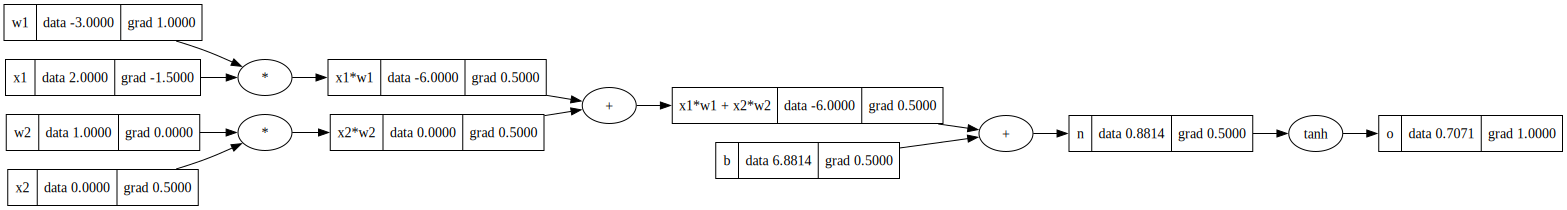

In [30]:
o.backward()
draw_dot(o)

**Bug** - The gradients are overriden if same node is repeated rather than accumulating

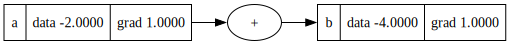

In [31]:
a = Value(-2.0, label='a')
b = a + a; b.label='b'
b.backward()
draw_dot(b)

**a.grad should be 2 rather than 1**

In [32]:
class Value:
    def __init__(self, data, _children=(), _op="", label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad

        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad

        out._backward = _backward
        return out

    def __rmul__(self, other):
        return self * other

    def tanh(self):
        e = math.exp(2 * self.data)
        t = (e - 1) / (e + 1)
        out = Value(t, (self,), "tanh")

        def _backward():
            self.grad += (1 - t**2) * out.grad

        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), "exp")
        
        def _backward():
            self.grad += out.data * out.grad
        
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**-1
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers for now"
        out = Value(self.data ** other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * self.data ** (other - 1) * out.grad
        out._backward = _backward
        
        return out
    
    def __sub__(self, other):
        return self + (-other)
    
    def __neg__(self):
        return self * -1
    
    def __radd__(self, other):
        return self + other

    def backward(self):
        # build topological graph
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

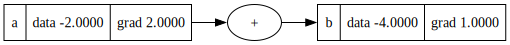

In [33]:
a = Value(-2.0, label="a")
b = a + a
b.label = "b"
b.backward()
draw_dot(b)

In [34]:
a, b = 10, 2
a / b, a * (1/b), a * (b**-1)

(5.0, 5.0, 5.0)

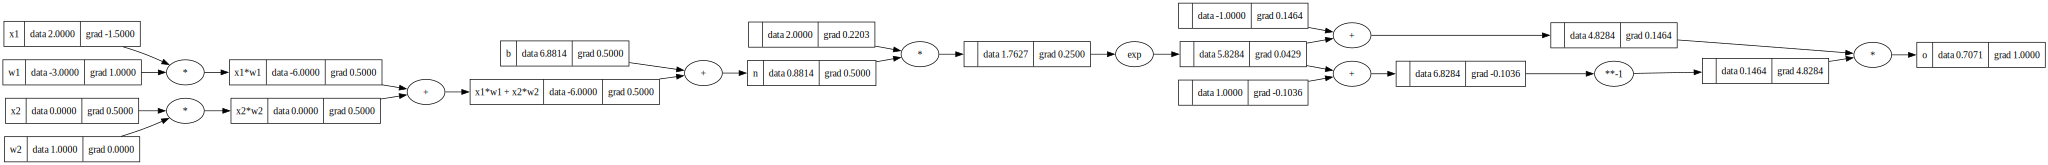

In [35]:
# inputs
x1 = Value(2.0, label="x1")
x2 = Value(0.0, label="x2")
# weights
w1 = Value(-3.0, label="w1")
w2 = Value(1.0, label="w2")
# bias
b = Value(6.8813735870195432, label="b")

x1w1 = x1 * w1
x1w1.label = "x1*w1"
x2w2 = x2 * w2
x2w2.label = "x2*w2"
x1w1x2w2 = x1w1 + x2w2
x1w1x2w2.label = "x1*w1 + x2*w2"
n = x1w1x2w2 + b
n.label = "n"
# --
e = (2*n).exp()
o = (e-1) / (e+1)
# -- 
o.label = "o"
o.backward()
draw_dot(o)

In [36]:
import torch

x1 = torch.Tensor([2.0]).double()
x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()
x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()
w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()
w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()
b.requires_grad = True
n = x1 * w1 + x2 * w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print("---")
print("x2", x2.grad.item())
print("w2", w2.grad.item())
print("x1", x1.grad.item())
print("w1", w1.grad.item())


0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [37]:
import random

class Neuron:
    
    def __init__(self, n_inp):
        self.w = [ Value(random.uniform(-1, 1)) for _ in range(n_inp)]
        self.b = Value(random.uniform(-1, 1))
    
    def __call__(self, x):
        # w * x + b
        act = sum([ wi*xi for wi, xi in zip(self.w, x)] , self.b)
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]

class Layer:
    
    def __init__(self, n_inp, n_out):
        self.neurons = [ Neuron(n_inp) for _ in range(n_out) ]
    
    def __call__(self, x):
        outs = [ n(x) for n in self.neurons ]
        return outs[0] if len(outs) == 1 else outs
    
    def parameters(self):
        return [ p for neuron in self.neurons for p in neuron.parameters() ]
    
class MLP:
    
    def __init__(self, n_inp, n_outs):
        sz = [n_inp] + n_outs
        self.layers = [ Layer(sz[i], sz[i+1]) for i in range(len(sz)-1) ]
    
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x
    
    def parameters(self):
        return [ p for layer in self.layers for neuron in layer.neurons for p in neuron.parameters() ]

In [38]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data=-0.41026557523645774)

In [39]:
len(n.parameters())

41

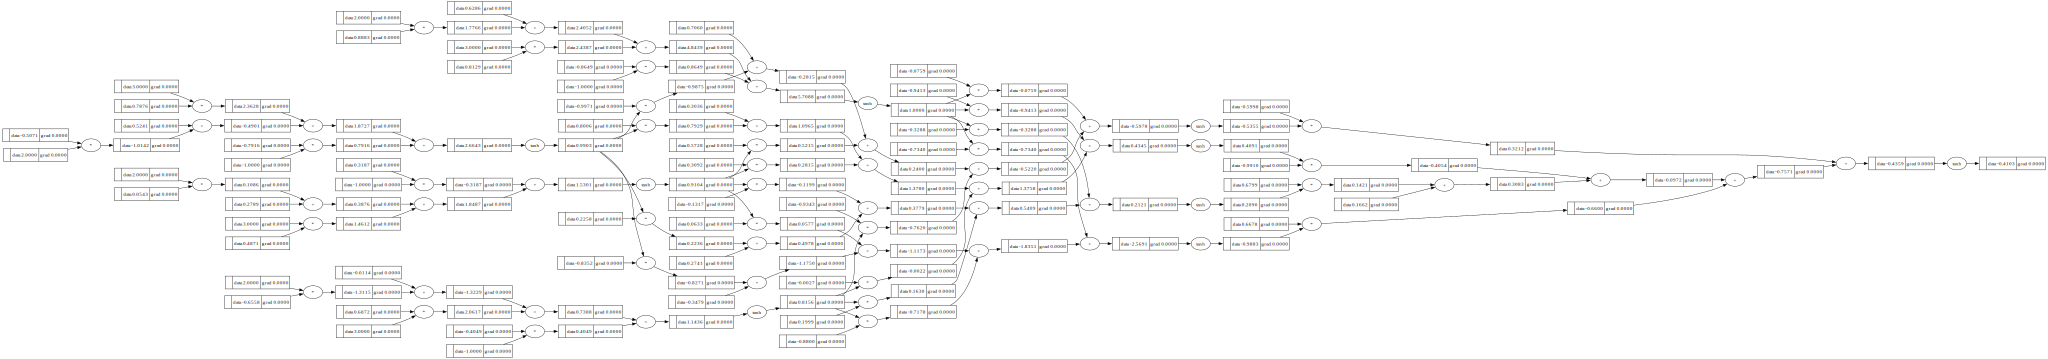

In [40]:
draw_dot(n(x))

In [41]:
xs = [
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]
ypred = [ n(x) for x in xs ]
ypred

[Value(data=-0.41026557523645774),
 Value(data=0.47239125416566785),
 Value(data=-0.6869434135554251),
 Value(data=-0.36209961685516445)]

In [42]:
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=6.110104790593881)

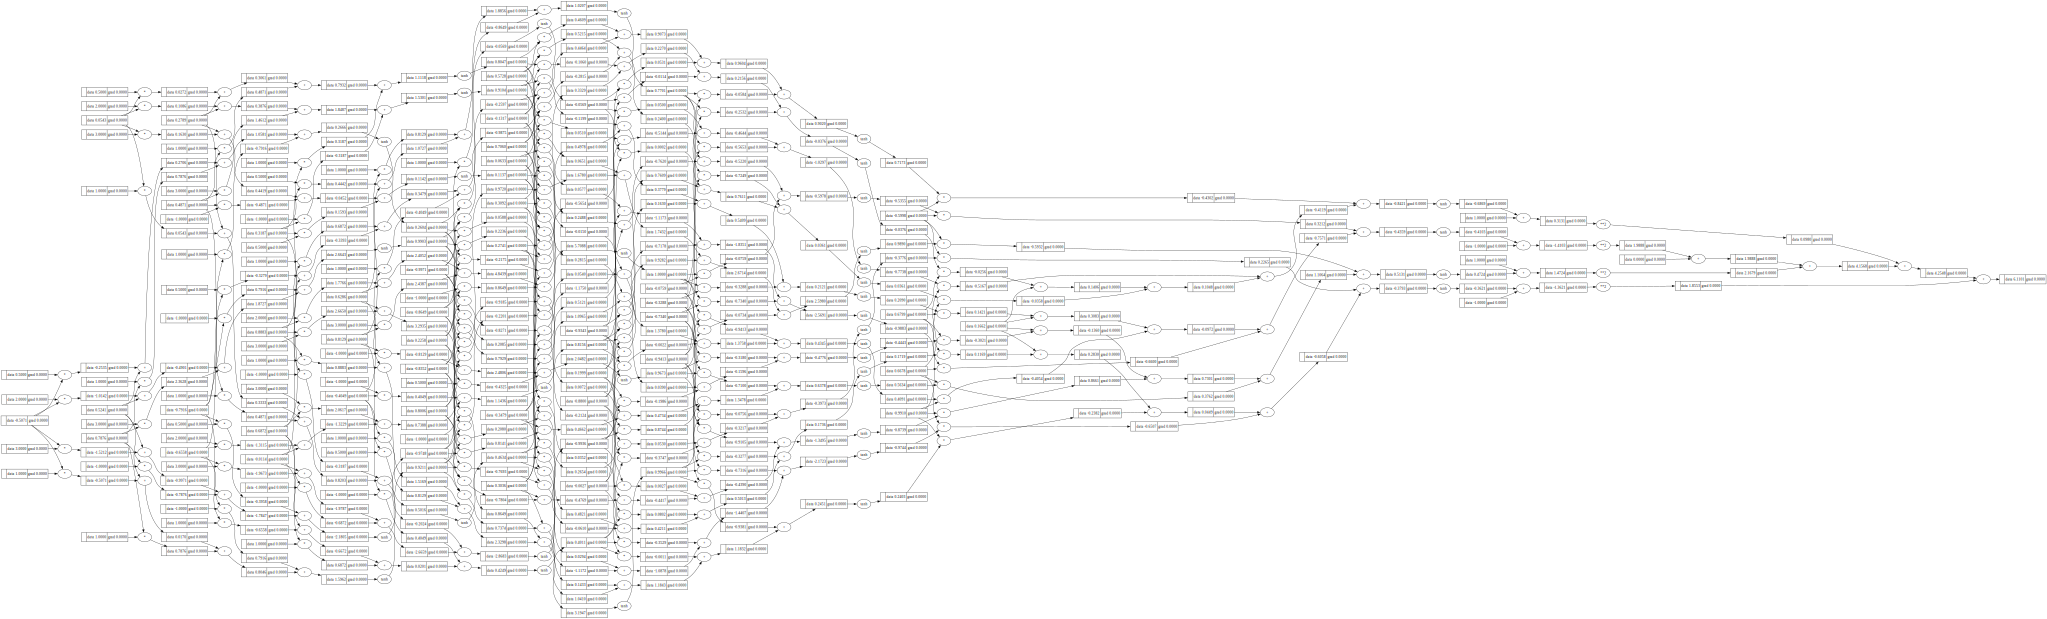

In [43]:
draw_dot(loss)

In [44]:
lr = 0.1
for k in range(10):
    # forward pass
    ypred = [ n(x) for x in xs ]
    loss = sum((yout - ygt) ** 2 for ygt, yout in zip(ys, ypred))
    # backward pass 
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    # update
    for p in n.parameters():
        p.data += -lr * p.grad
    
    print(k, loss.data)

0 6.110104790593881
1 3.657194781991029
2 0.5140395513679036
3 0.03320698658142094
4 0.02898567198448413
5 0.025837135134133413
6 0.023387184022076183
7 0.021418772953851552
8 0.019797101273804168
9 0.018433916022533307


In [45]:
print(loss)
print(ys)
ypred = [ n(x) for x in xs ]
print(ypred)

Value(data=0.018433916022533307)
[1.0, -1.0, -1.0, 1.0]
[Value(data=0.9596692295838036), Value(data=-0.92752125074794), Value(data=-0.9100135242837024), Value(data=0.9521288272912143)]
